
# Project 1



The following code is the formulation given by the professor, After this one is a formulation by me using variable thrust and motor gimble. 

[1] loss: 6220.595


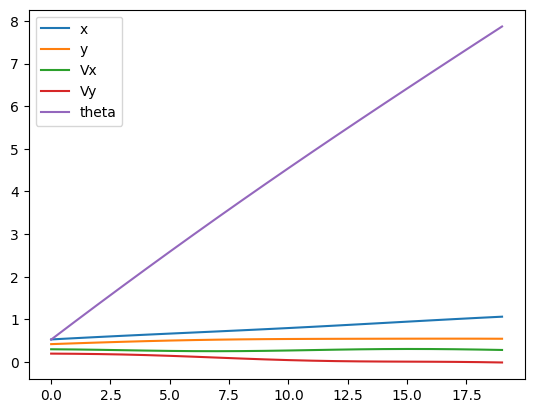

[2] loss: 5457.750


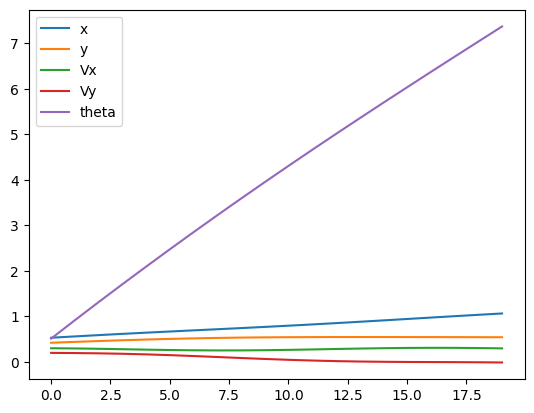

[3] loss: 4996.251


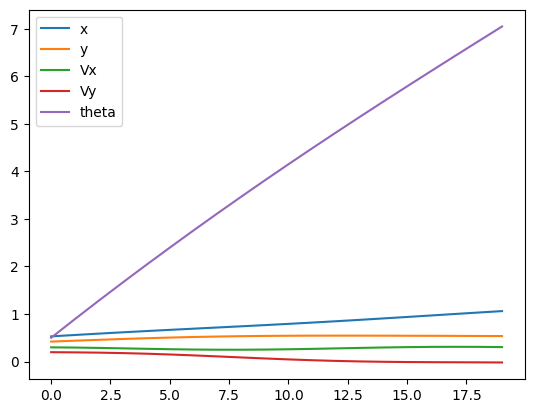

[4] loss: 4571.751


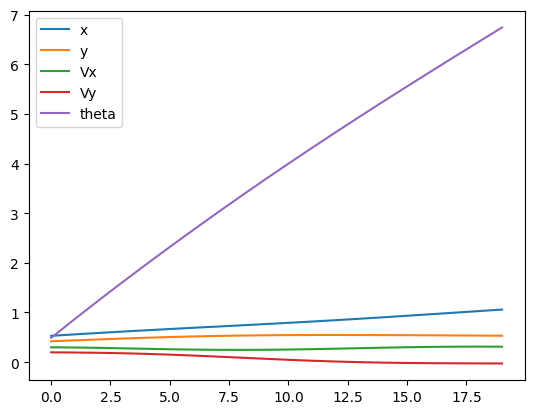

[5] loss: 4155.131


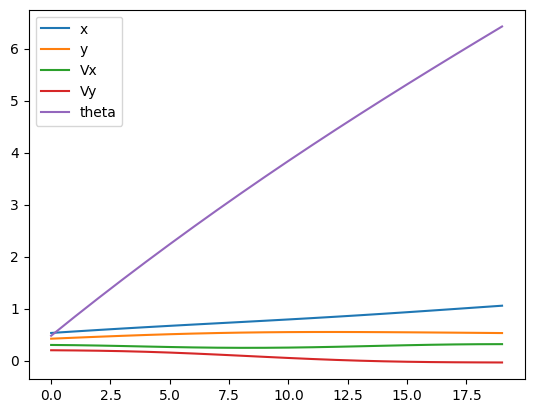

[6] loss: 3813.031


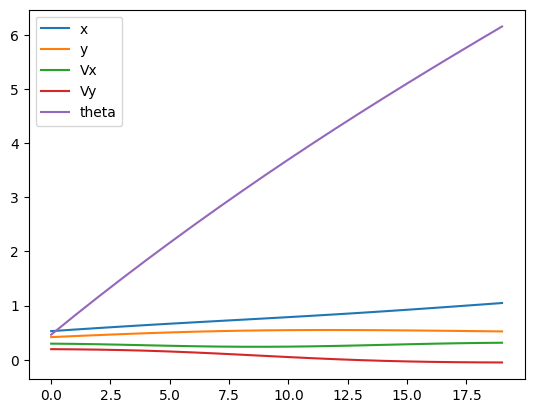

[7] loss: 3342.377


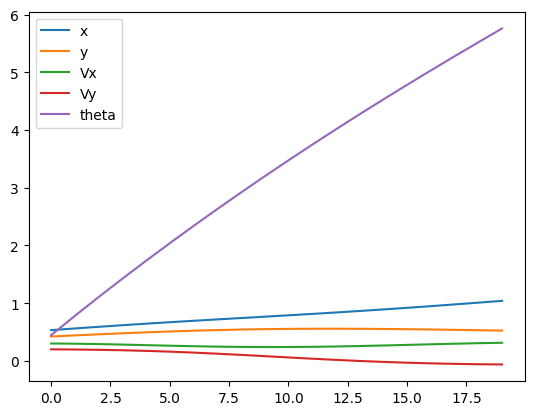

[8] loss: 2877.892


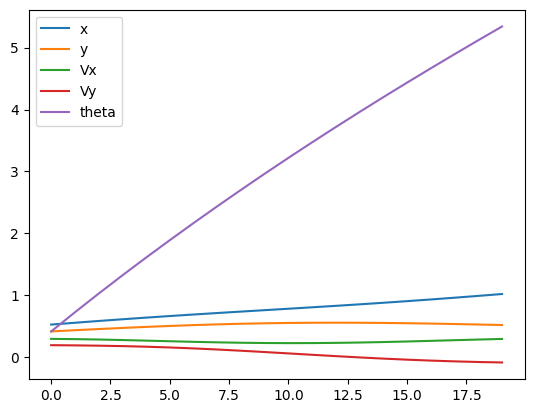

[9] loss: 2515.150


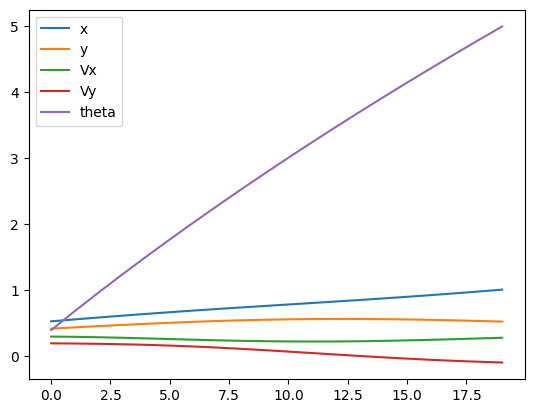

[10] loss: 2243.705


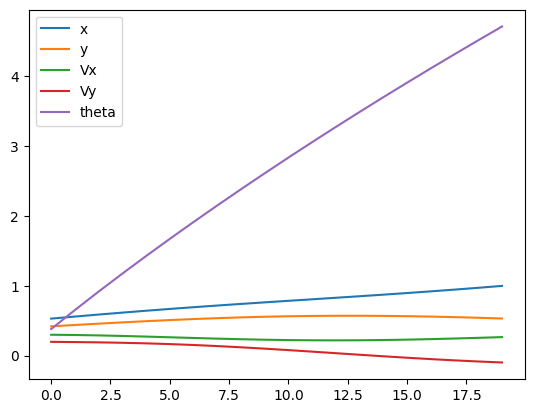

[11] loss: 2005.607


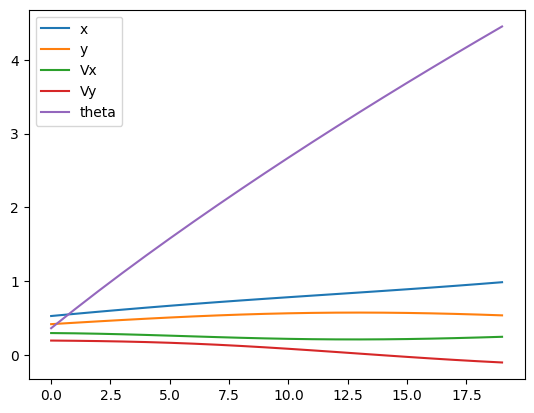

[12] loss: 1754.660


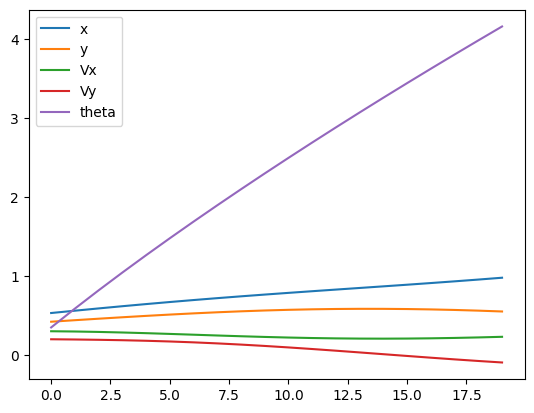

[13] loss: 1567.096


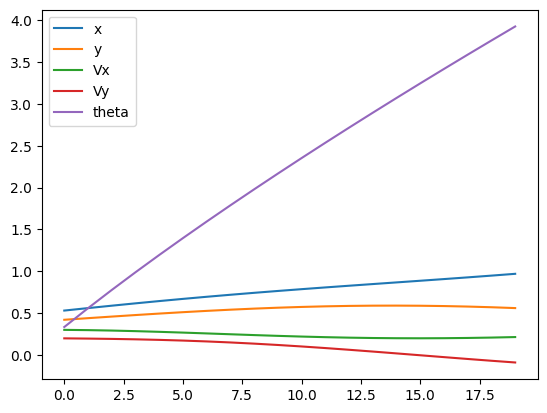

[14] loss: 1402.705


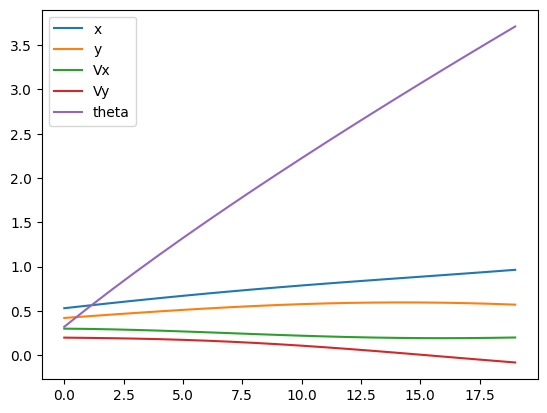

[15] loss: 1224.218


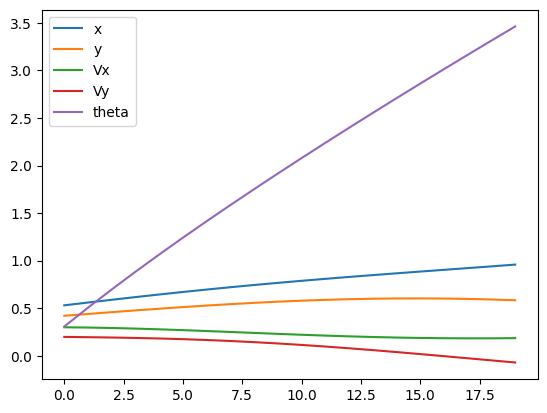

[16] loss: 1093.703


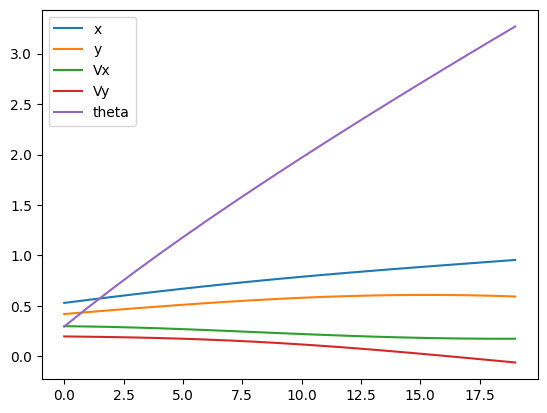

[17] loss: 986.044


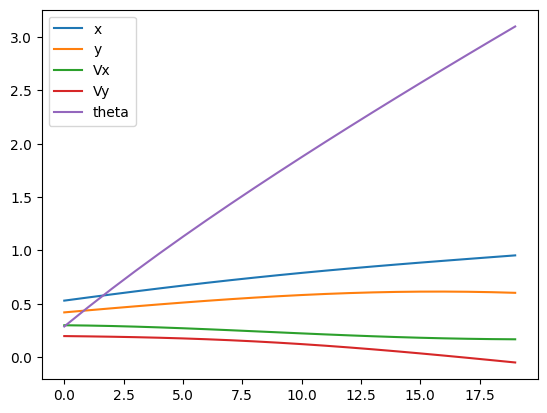

[18] loss: 881.021


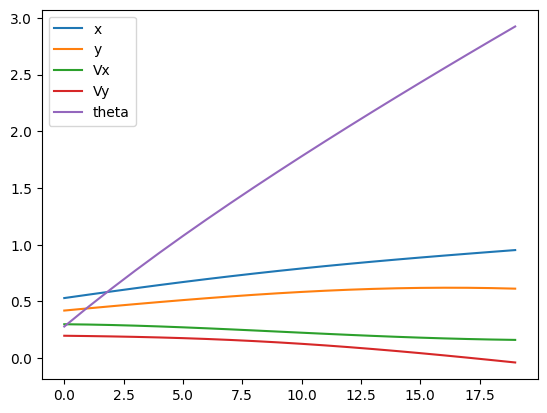

[19] loss: 795.396


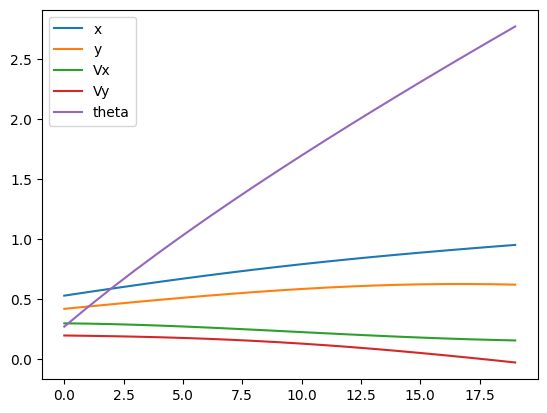

[20] loss: 716.590


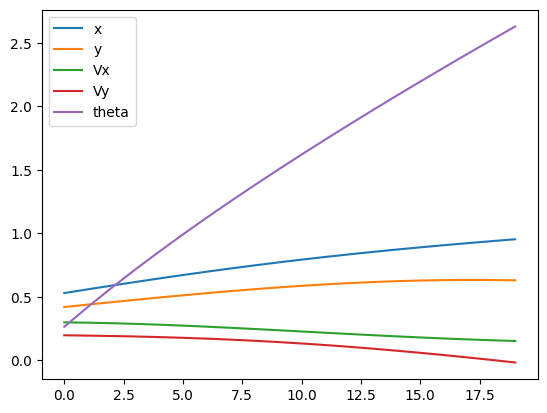

[21] loss: 627.367


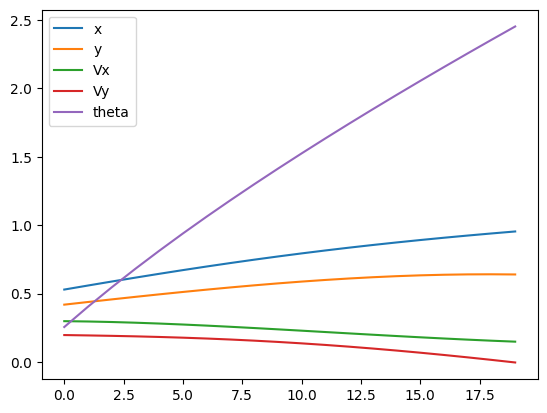

[22] loss: 542.198


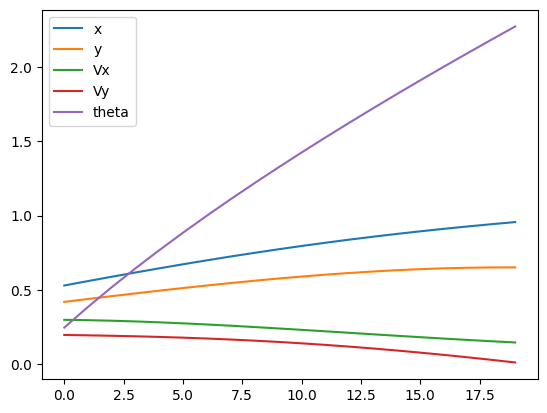

[23] loss: 471.819


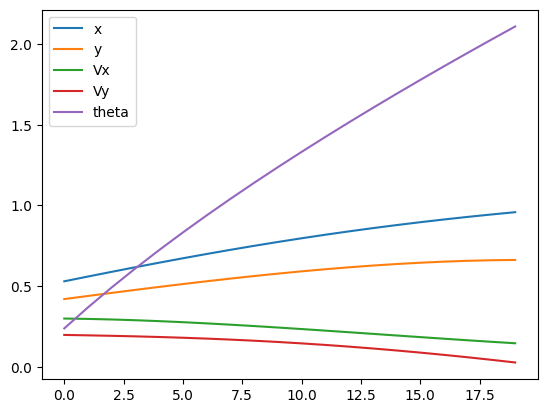

[24] loss: 396.105


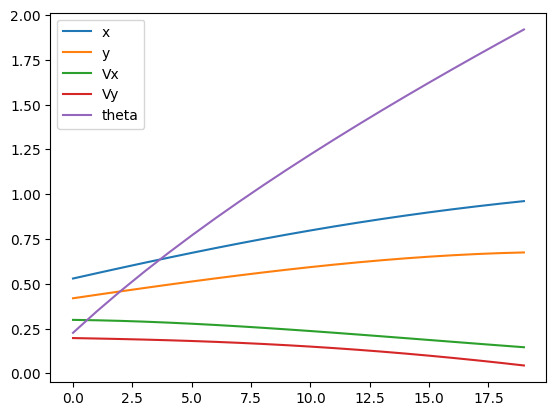

[25] loss: 344.304


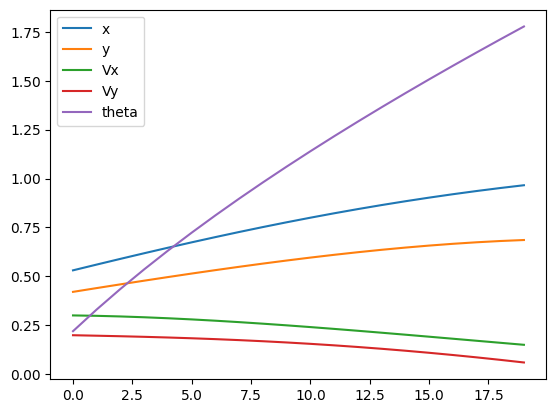

[26] loss: 302.519


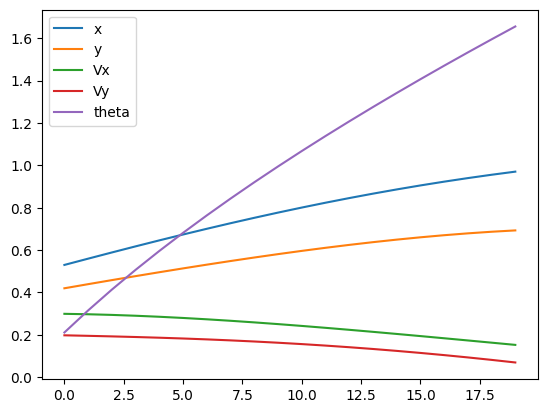

[27] loss: 270.238


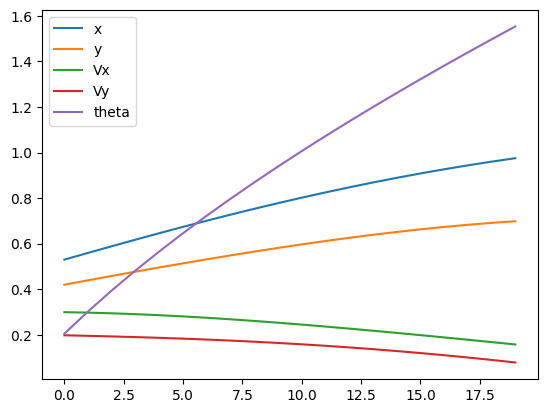

[28] loss: 241.110


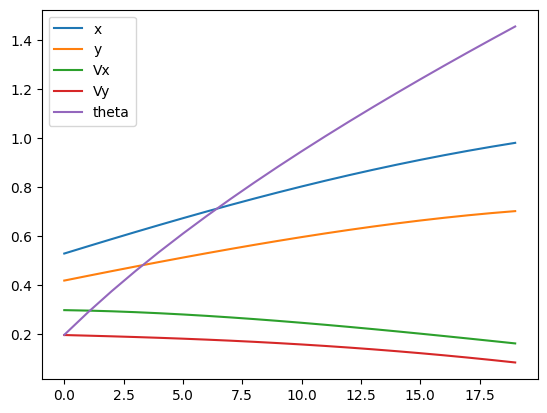

[29] loss: 214.070


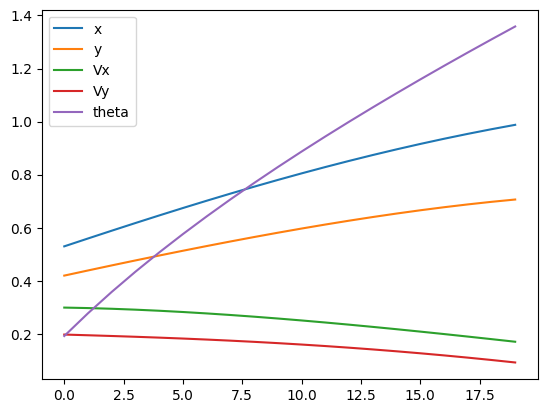

[30] loss: 190.962


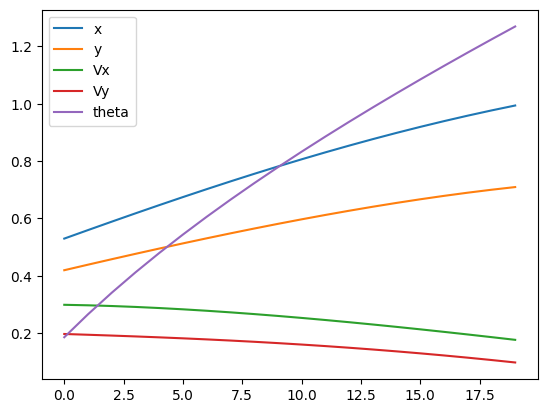

[31] loss: 170.532


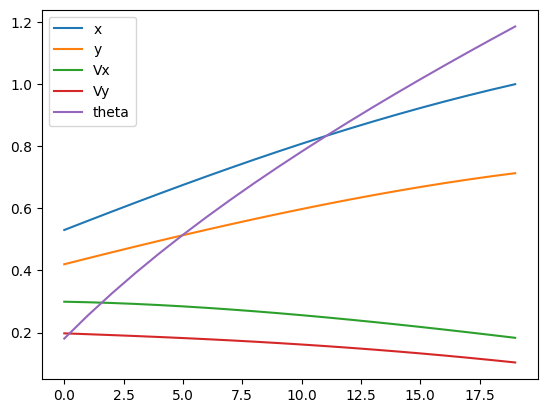

[32] loss: 153.812


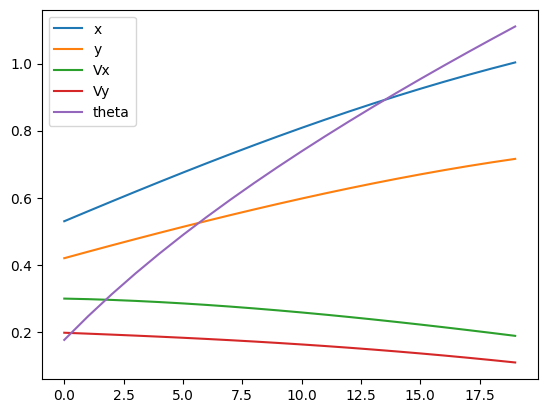

[33] loss: 139.939


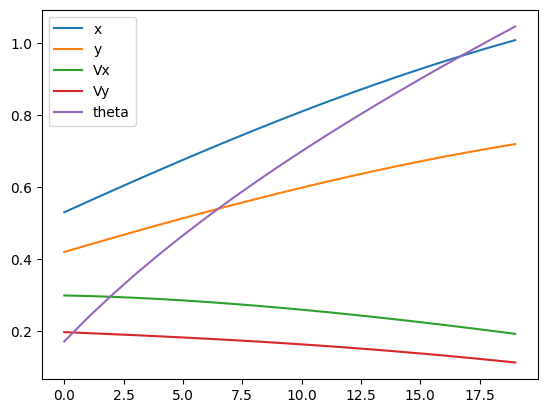

[34] loss: 128.049


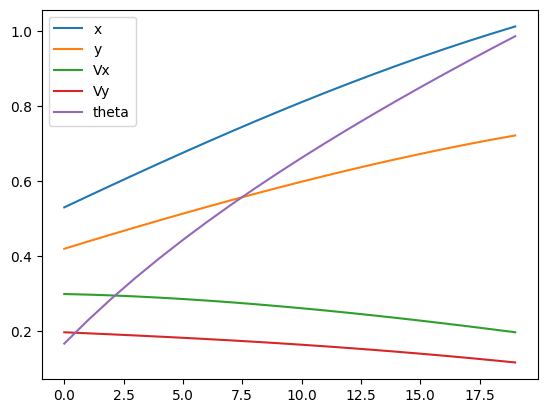

[35] loss: 113.225


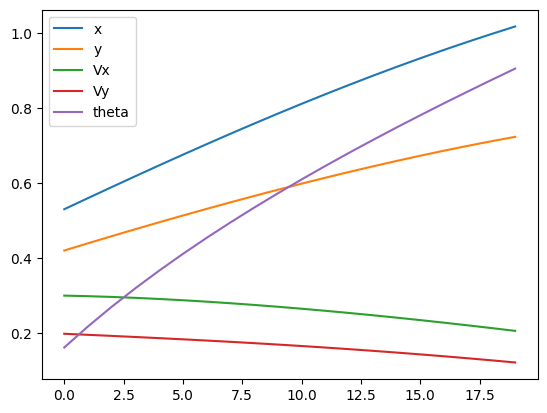

[36] loss: 101.343


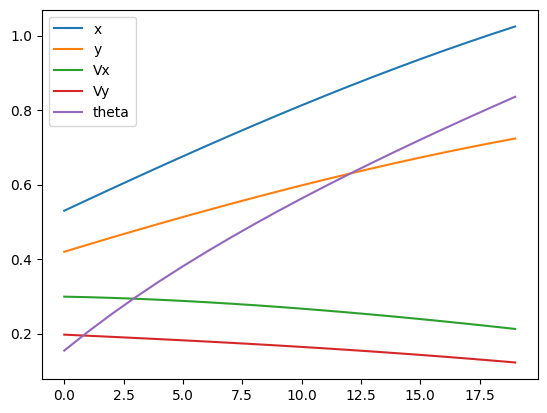

[37] loss: 90.156


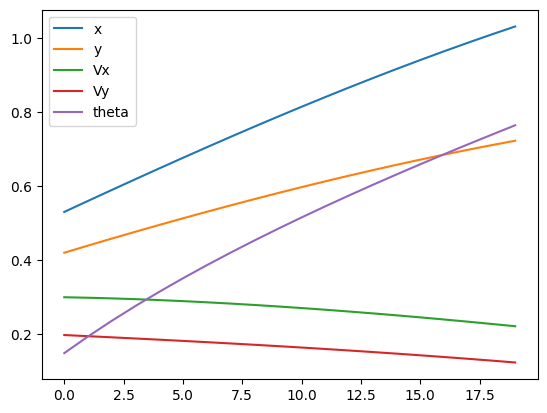

[38] loss: 81.391


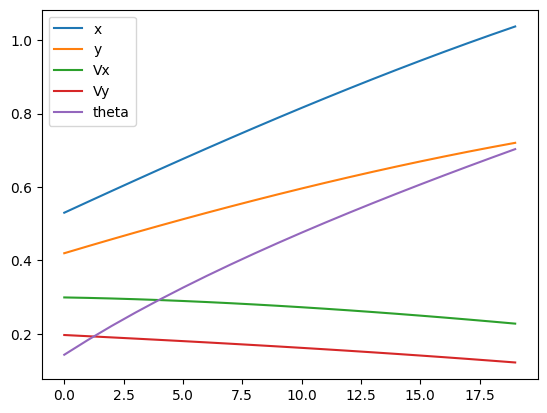

[39] loss: 74.742


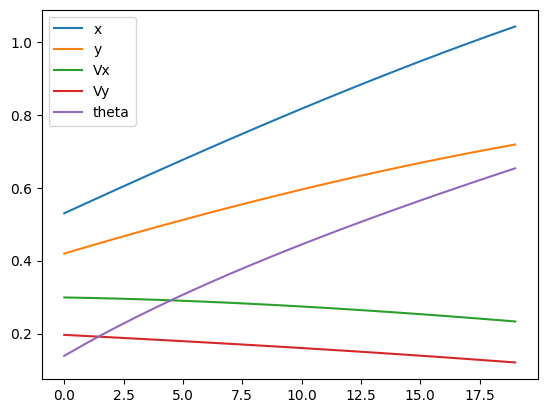

[40] loss: 69.563


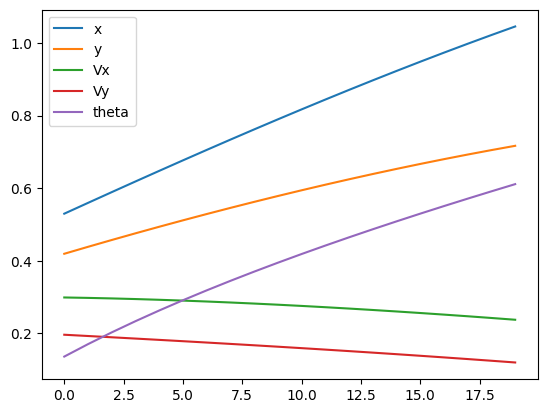

In [9]:

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
t.manual_seed(0)

# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        
        # gravity tensor, only affects the second state
        delta_state_gravity = - GRAVITY_ACCEL * t.tensor([0., 0.5 * FRAME_TIME**2, 0., FRAME_TIME, 0.])

        # first action tensor
        sin_value = t.sin(state[4])
        cos_value = t.cos(state[4])

        state_tensor = t.tensor([-0.5 * (FRAME_TIME ** 2) * sin_value,
                                    0.5 * (FRAME_TIME ** 2) * cos_value,
                                    -FRAME_TIME * sin_value,
                                    FRAME_TIME * cos_value,
                                    0.])

        delta_state = BOOST_ACCEL * t.mul(state_tensor,action[0])

        # Second action tensor
        delta_state_theta = t.mul(t.tensor([0., 0., 0., 0., 1.]), action[1])

        # update state
        state = state + delta_state + delta_state_gravity + delta_state_theta

        # step forward
        step_mat = t.tensor([[1., 0., FRAME_TIME, 0., 0.],
                             [0., 1., 0., FRAME_TIME, 0.],
                             [0., 0., 1., 0., 0.],
                             [0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., 1.]])

        state = t.matmul(step_mat,state)
        

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        '''
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)
        '''
        return state

# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [0.5,0.4,0.3,0.2,0.1]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        weights = t.tensor([20.,20.,1.,1.,100.])
        return t.matmul(weights.T,t.square(state))

# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.001)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.plot(data[:, 0],label='x')
        plt.plot(data[:, 1],label='y')
        plt.plot(data[:, 2],label='Vx')
        plt.plot(data[:, 3],label='Vy')
        plt.plot(data[:, 4],label='theta')
        plt.legend()
        plt.show()

# Now it's time to run the code!

T = 20  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem



### Formulation of Rocket with gimble and variable thrust

Let the state space be $ X = \left[ x,y,\theta,V_x,V_y,\omega \right]^T$

where $x$ and $y$ are distance, $V_x$ and $V_y$ are Velocities, $\theta$ is the orientation, and $\omega$ is angular velocity. 

Let the action variables be $ A = \left[ F_T, \beta\right]$

where $F_T$ is the variable thrust and $\beta$ is the gimble angle of the motor. 

Define $ \gamma = \theta + \beta$

![h function](Formulation1.png)

From the above diagram we can write continous non linear dynamics in state space form: 

\begin{equation*}
            \begin{bmatrix}
                x_1 \hspace{.2cm}
                x_2 \hspace{.2cm}
                x_3 \hspace{.2cm}
                x_4 \hspace{.2cm}
                x_5 \hspace{.2cm}
                x_6
            \end{bmatrix}^T
            =
            \begin{bmatrix}
                x \hspace{.2cm}
                y\hspace{.2cm}
                \theta\hspace{.2cm}
                \dot{x}\hspace{.2cm}
                \dot{y}\hspace{.2cm}
                \dot{\theta}
            \end{bmatrix}^T
            
\end{equation*}

\begin{equation*}
            \begin{bmatrix}
                \dot{x_1} \\
                \dot{x_2} \\
                \dot{x_3} \\
                \dot{x_4} \\
                \dot{x_5} \\
                \dot{x_6} \\
            \end{bmatrix}
            =
            \begin{bmatrix}
                \dot{x} \\
                \dot{y} \\
                \dot{\theta} \\
                \ddot{x} \\
                \ddot{y} \\
                \ddot{\theta} \\
            \end{bmatrix}_{k+1}
            = 
            \begin{bmatrix}
                x_4\\
                x_5 \\
                x_6 \\
                \frac{-F_T \sin(x_3 + \beta)}{m} \\
                \frac{F_T \cos(x_3 + \beta)}{m} - g \\ 
                \frac{- 12 F_T \sin(\beta) }{ml^2}\\ 
            \end{bmatrix}_k
\end{equation*}

Discretize the state space: 

\begin{equation*}
            \begin{bmatrix}
                x_1 \\
                x_2 \\
                x_3 \\
                x_4 \\
                x_5 \\
                x_6 \\
            \end{bmatrix}
            = 
            \begin{bmatrix}
                x_1 + T_s x_4 \\
                x_2 + T_s x_5 \\
                x_3 + T_s x_6 \\
                x_4 + T_s\left(\frac{-F_T \sin(x_3 + \beta)}{m}\right) \\
                x_5 + T_s\left(\frac{F_T \cos(x_3 + \beta)}{m} - g\right) \\ 
                x_6 + T_s\left(\frac{- 12 F_T \sin(\beta) }{ml^2}\right)\\ 
            \end{bmatrix}
\end{equation*}

Now the code: